In [7]:
import json
import pandas as pd
import numpy as np

import re

from sqlalchemy import create_engine
#import psycopg2

# from config import db_password

import time

In [15]:
# 1. Add the clean movie function that takes in the argument, "movie".
def clean_movie(movie):
    
    movie=dict(movie)
    alt_titles={}
    for key in ['Also known as','Arabic','Cantonese','Chinese','French',
                'Hangul','Hebrew','Hepburn','Japanese','Literally',
                'Mandarin','McCune–Reischauer','Original title','Polish',
                'Revised Romanization','Romanized','Russian',
                'Simplified','Traditional','Yiddish']:
        if key in movie:
            alt_titles[key]=movie[key]
            movie.pop(key)
            
        if len(alt_titles)>0:
            movie['alt_titles']=alt_titles
            
        def change_column_name(old_name, new_name):
            if old_name in movie:
                movie[new_name]=movie.pop(old_name)
    
        
        change_column_name('Adaptation by', 'Writer(s)')
        change_column_name('Country of origin', 'Country')
        change_column_name('Directed by', 'Director')
        change_column_name('Distributed by', 'Distributor')
        change_column_name('Edited by', 'Editor(s)')
        change_column_name('Length', 'Running time')
        change_column_name('Original release', 'Release date')
        change_column_name('Music by', 'Composer(s)')
        change_column_name('Produced by', 'Producer(s)')
        change_column_name('Producer', 'Producer(s)')
        change_column_name('Productioncompanies ', 'Production company(s)')
        change_column_name('Productioncompany ', 'Production company(s)')
        change_column_name('Released', 'Release Date')
        change_column_name('Release Date', 'Release date')
        change_column_name('Screen story by', 'Writer(s)')
        change_column_name('Screenplay by', 'Writer(s)')
        change_column_name('Story by', 'Writer(s)')
        change_column_name('Theme music composer', 'Composer(s)')
        change_column_name('Written by', 'Writer(s)')
    
    

    return movie

In [16]:
# 1 Add the function that takes in three arguments;
# Wikipedia data, Kaggle metadata, and MovieLens rating data (from Kaggle)

def extract_transform_load(f1,f2,f3):
    # 2. Read in the kaggle metadata and MovieLens ratings CSV files as Pandas DataFrames.
    kaggle_metadata=pd.read_csv(kaggle_file,low_memory=False)
    kaggle_metadata.head()
    
    ratings=pd.read_csv(ratings_file )

    # Open and read the Wikipedia data JSON file.
    
    with open(wiki_file, mode='r') as file:
        
        wiki_movies_raw=json.load(file)
    # 3. Write a list comprehension to filter out TV shows.
        wiki_movies=[movie for movie in wiki_movies_raw 
                     if "Directed by" in movie or
                    "Directore" in movie and 
                    'imdb_link' in movie and 
                    "No. of episodes" not in movie ]

    # 4. Write a list comprehension to iterate through the cleaned wiki movies list
    # and call the clean_movie function on each movie.
    
    clean_movies= [clean_movie(movie) for movie in wiki_movies ]
    # 5. Read in the cleaned movies list from Step 4 as a DataFrame.
    wiki_movies_df=pd.DataFrame(clean_movies)

    # 6. Write a try-except block to catch errors while extracting the IMDb ID using a regular expression string and
    #  dropping any imdb_id duplicates. If there is an error, capture and print the exception.
#     try:
#         movie['imdb_id']=movie["imdb_link"].str.extract(r'tt\d{7}')
#         wiki_movies_df.drop_duplicates(subset='imdb_id', inpalce=True)
#         print('XXXXXX',movie["imdb_id"])
        
#     except:
#         pass
        
        
    wiki_movies_df['imdb_id'] = wiki_movies_df['imdb_link'].str.extract(r'(tt\d{7})')
    print(len(wiki_movies_df))
    wiki_movies_df.drop_duplicates(subset='imdb_id', inplace=True)
    print(len(wiki_movies_df))
    wiki_movies_df["imdb_id"]
        

    #  7. Write a list comprehension to keep the columns that don't have null values from the wiki_movies_df DataFrame.
    columns_to_keep=[column for column in wiki_movies_df.columns if wiki_movies_df[column].isnull().sum() < len(wiki_movies_df) * 0.9]  
    wiki_movies_df=wiki_movies_df[columns_to_keep]

    # 8. Create a variable that will hold the non-null values from the “Box office” column.
        
     
        #box_office=wiki_movies_df["Box office"].dropna()
    box_office=wiki_movies_df["Box office"].dropna()
    # 9. Convert the box office data created in Step 8 to string values using the lambda and join functions.
    box_office=box_office.apply(lambda x: ''.join(x) if type(x)==list else x)

    # 10. Write a regular expression to match the six elements of "form_one" of the box office data.
    form_one=r'\$\s*\d+\.?\d*\s*[mb]illi?on'
   
    # 11. Write a regular expression to match the three elements of "form_two" of the box office data.
    form_two=r'\$\S*\d{1:3}(?:[,\.]\d{3})+(?!\s*[mb]illion)'
    box_office=box_office.replace(r'\$.*[---](?![a-z])','$',regex=True)
        

    # 12. Add the parse_dollars function.
    def parse_dollars(s):
            if type(s) != str:
                return np.nan
            
            if re.match(r'\$\s*\d+\.?\d*\s*milli?on',s,flags=re.I):
                
                s=re.sub('\$|\s|[a-zA-Z]','',s)
                value=float(s) * 10**6
                return value
            
            elif re.match(r'\$\s*\d+\.?\d*\s*billi?on',s,flags=re.I):
                 
                   
                s=re.sub('\$|\s|[a-zA-Z]','',s)
                
                value=float(s) * 10**9
                return value
                
            elif re.match(r'\$\S*\d{1:3}(?:[,\.]\d{3})+(?!\s*[mb]illion)',s,flags=re.I):
                
                s=re.sub('\$|\s|\,|\.','',s)
                value=float(s)
                return value
            
            else:
                
                return np.nan
            
            
    
    
        
    # 13. Clean the box office column in the wiki_movies_df DataFrame.
          
    wiki_movies_df['box_office'] = box_office.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)
   
    # 14. Clean the budget column in the wiki_movies_df DataFrame.
    budget=wiki_movies_df["Budget"].dropna()
    budget=budget.map(lambda x : "".join(x) if type(x)==list else x)
    budget = budget.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)
    budget = budget.str.replace(r'\[\d+\]\s*', '')
    
    wiki_movies_df["budget"]=budget.str.extract(f'({form_one}|{form_two})',flags=re.IGNORECASE)[0].apply(parse_dollars)
    #wiki_movies_df.drop('Budget', axis=1, inplace=True)
    # 15. Clean the release date column in the wiki_movies_df DataFrame.
    release_date=wiki_movies_df['Release date'].dropna().map(lambda x: ''.join(x) if type(x)==list else x)
    form_1=r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s[123]?\d,\s\d{4}'
    form_2=r'\d{4}.[01]\d.[0123]\d'
    form_3= r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s\d{4}'
    form_4=r'\d{4}'
    
    wiki_movies_df['release_date']=pd.to_datetime(release_date.str.extract(f'({form_1}|{form_2}|{form_3}|{form_4})')[0],infer_datetime_format=True)
    wiki_movies_df.drop('Release date', axis=1, inplace=True)
    # 16. Clean the running time column in the wiki_movies_df DataFrame.
    running_time=wiki_movies_df['Running time'].dropna().map(lambda x: ''.join(x) if type(x)==list else x)
    running_time_extract=running_time.str.extract(r'(\d+)\s?ho?u?r?s?\s*(\d*)|(\d+)\s+m')
    running_time_extract=running_time_extract.apply(lambda col: pd.to_numeric(col, errors='coerce'))
    wiki_movies_df['running_time']=running_time_extract.apply(lambda row:row[0]*60+row[1] if row[1]!=0 else row[2],axis=1 )
    # Return three variables. The first is the wiki_movies_df DataFrame
    wiki_movies_df.drop('Running time',axis=1,inplace=True)
    
     
    # 2. Clean the Kaggle metadata.
    kaggle_metadata = kaggle_metadata[kaggle_metadata['adult'] == 'False'].drop('adult',axis='columns')
    #we need to change the type to boolean instead of object
    
    
    kaggle_metadata['video']= kaggle_metadata['video']==True
    kaggle_metadata['budget']=pd.to_numeric(kaggle_metadata['budget'],errors='raise')
    kaggle_metadata['id']=pd.to_numeric(kaggle_metadata['id'],errors='raise')
    kaggle_metadata['popularity']=pd.to_numeric(kaggle_metadata['popularity'],errors='raise')
    
    kaggle_metadata['release_date']=pd.to_datetime(kaggle_metadata['release_date'] )
    
    print(wiki_movies_df['imdb_id'])
    kaggle_metadata.drop_duplicates(subset='imdb_id')
    wiki_movies_df.drop_duplicates(subset='imdb_id')
    # 3. Merged the two DataFrames into the movies DataFrame.
    movies_df=pd.merge(wiki_movies_df, kaggle_metadata, on ='imdb_id',suffixes=['_wiki','_kaggle'])    # 4. Drop unnecessary columns from the merged DataFrame.
    movies_df[movies_df['title_kaggle'] !=movies_df['title_wiki']][['title_kaggle','title_wiki']]
 
    movies_df[(movies_df['title_kaggle']=='' )| (movies_df['title_kaggle'].isnull())]
    #the plot below will show us we should keep the runtime bc there are a lot of y that there is no x for it
    movies_df.fillna(0).plot(x='running_time', y='runtime',kind='scatter')
    movies_df.drop(columns=['title_wiki','release_date_wiki','Language','Production company(s)'], inplace=True)
    
    
    # 5. Add in the function to fill in the missing Kaggle data.

    def missing_kaggle_data(df,kaggle_column,wiki_column):
        df[kaggle_column]=df.apply(lambda row: row[wiki_column] if row[kaggle_column]==0 else row[kaggle_column] ,axis=1)
        df.drop(columns=wiki_column ,inplace=True)
    # 6. Call the function in Step 5 with the DataFrame and columns as the arguments.
    missing_kaggle_data(movies_df,'runtime','running_time')
    missing_kaggle_data(movies_df, 'budget_kaggle', 'budget_wiki')
    missing_kaggle_data(movies_df,'revenue', 'box_office')

    # 7. Filter the movies DataFrame for specific columns.
    for col in movies_df:
        convert_list_to_tuple= lambda x: tuple(x) if type(x)==list else x
        count_values=movies_df[col].apply(convert_list_to_tuple).value_counts(dropna=False)
        lenght_of=len(count_values)
        print(col,lenght_of)
        if lenght_of == 1: 
            print(col)
            
    movies_df.loc[:,['imdb_id','id','title_kaggle','original_title','tagline','belongs_to_collection','url','imdb_link',
                       'runtime','budget_kaggle','revenue','release_date_kaggle','popularity','vote_average','vote_count',
                       'genres','original_language','overview','spoken_languages','Country',
                       'production_companies','production_countries','Distributor',
                       'Producer(s)','Director','Starring','Cinematography','Editor(s)','Writer(s)','Composer(s)','Based on'
                      ]]     

    # 8. Rename the columns in the movies DataFrame.
    movies_df.rename({'id':'kaggle_id',
                  'title_kaggle':'title',
                  'url':'wikipedia_url',
                  'budget_kaggle':'budget',
                  'release_date_kaggle':'release_date',
                  'Country':'country',
                  'Distributor':'distributor',
                  'Producer(s)':'producers',
                  'Director':'director',
                  'Starring':'starring',
                  'Cinematography':'cinematography',
                  'Editor(s)':'editors',
                  'Writer(s)':'writers',
                  'Composer(s)':'composers',
                  'Based on':'based_on'
                 }, axis='columns', inplace=True)

    # 9. Transform and merge the ratings DataFrame.
    ratings['timestamp'] =pd.to_datetime(ratings['timestamp'],unit='s')
    rating_counts = ratings.groupby(['movieId','rating'], as_index=False).count() \
                .rename({'userId':'count'}, axis=1) \
                .pivot(index='movieId',columns='rating', values='count')
    rating_counts.columns=['__rating' + str(col) for col in rating_counts.columns]
    
    movies_with_ratings_df=pd.merge(movies_df,rating_counts, left_on='kaggle_id', right_index=True, how='left')
    movies_with_ratings_df[rating_counts.columns]= movies_with_ratings_df[rating_counts.columns].fillna(0)
    
    return wiki_movies_df, movies_with_ratings_df, movies_df


In [17]:
# 17. Create the path to your file directory and variables for the three files.
file_dir ='/Users/elhamamini/Desktop/Class/Movies-ETL'
# The Wikipedia data
wiki_file = f'{file_dir}/wikipedia-movies.json'
# The Kaggle metadata
kaggle_file = f'{file_dir}/movies_metadata.csv'
# The MovieLens rating data.
ratings_file = f'{file_dir}/ratings.csv'

7103
7036


/Users/elhamamini/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/pandas/core/dtypes/inference.py:178: FutureWarning: Possible set difference at position 6
  re.compile(obj)
/Users/elhamamini/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/ipykernel_launcher.py:109: FutureWarning: The default value of regex will change from True to False in a future version.


0       tt0098987
1       tt0098994
2       tt0099005
3       tt0099012
4       tt0099018
          ...    
7098    tt1255919
7099    tt6266538
7100    tt4669788
7101    tt7137380
7102    tt9495224
Name: imdb_id, Length: 7036, dtype: object
url 6052
year 29
imdb_link 6052
Based on 1796
Starring 5921
Cinematography 1644
Country 469
Budget 773
Box office 3466
Director 2917
Distributor 1351
Editor(s) 2729
Composer(s) 1937
Producer(s) 5176
Writer(s) 4546
imdb_id 6052
belongs_to_collection 570
budget_kaggle 357
genres 1245
homepage 1773
id 6068
original_language 19
original_title 6010
overview 6061
popularity 6068
poster_path 6062
production_companies 4329
production_countries 375
release_date_kaggle 3475
revenue 3982
runtime 149
spoken_languages 446
status 5
tagline 4905
title_kaggle 6010
video 2
vote_average 76
vote_count 1600


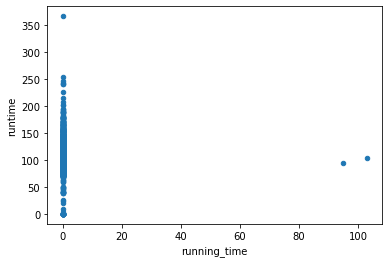

In [18]:
# 11. Set the three variables equal to the function created in D1.
wiki_file, kaggle_file, ratings_file = extract_transform_load(wiki_file, kaggle_file, ratings_file)

In [19]:
# 12. Set the DataFrames from the return statement equal to the file names in Step 11. 
wiki_movies_df = wiki_file
movies_with_ratings_df = kaggle_file
movies_df = ratings_file

In [20]:
# 13. Check the wiki_movies_df DataFrame. 
wiki_movies_df.head()

,url,year,imdb_link,title,Based on,Starring,Cinematography,Country,Language,Budget,...,Editor(s),Composer(s),Producer(s),Production company(s),Writer(s),imdb_id,box_office,budget,release_date,running_time
0,https://en.wikipedia.org/wiki/The_Adventures_o...,1990,https://www.imdb.com/title/tt0098987/,The Adventures of Ford Fairlane,"[Characters, by Rex Weiner]","[Andrew Dice Clay, Wayne Newton, Priscilla Pre...",Oliver Wood,United States,English,$20 million,...,Michael Tronick,"[Cliff Eidelman, Yello]","[Steve Perry, Joel Silver]",Silver Pictures,"[David Arnott, James Cappe]",tt0098987,21400000.0,20000000.0,1990-07-11,NaN
1,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",1990,https://www.imdb.com/title/tt0098994/,"After Dark, My Sweet","[the novel, After Dark, My Sweet, by, Jim Thom...","[Jason Patric, Rachel Ward, Bruce Dern, George...",Mark Plummer,United States,English,$6 million,...,Howard E. Smith,Maurice Jarre,"[Ric Kidney, Robert Redlin]",Avenue Pictures,"[James Foley, Robert Redlin]",tt0098994,2700000.0,6000000.0,1990-05-17,NaN
2,https://en.wikipedia.org/wiki/Air_America_(film),1990,https://www.imdb.com/title/tt0099005/,Air America,"[Air America, by, Christopher Robbins]","[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",Roger Deakins,United States,"[English, Lao]",$35 million,...,"[John Bloom, Lois Freeman-Fox]",Charles Gross,Daniel Melnick,"[Carolco Pictures, IndieProd Company]","[John Eskow, Richard Rush]",tt0099005,NaN,35000000.0,1990-08-10,NaN
3,https://en.wikipedia.org/wiki/Alice_(1990_film),1990,https://www.imdb.com/title/tt0099012/,Alice,NaN,"[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",Carlo Di Palma,United States,English,$12 million,...,Susan E. Morse,NaN,Robert Greenhut,NaN,Woody Allen,tt0099012,NaN,12000000.0,1990-12-25,NaN
4,https://en.wikipedia.org/wiki/Almost_an_Angel,1990,https://www.imdb.com/title/tt0099018/,Almost an Angel,NaN,"[Paul Hogan, Elias Koteas, Linda Kozlowski]",Russell Boyd,US,English,$25 million,...,David Stiven,Maurice Jarre,John Cornell,NaN,Paul Hogan,tt0099018,NaN,25000000.0,1990-12-19,NaN


In [21]:
# 14. Check the movies_with_ratings_df DataFrame.
movies_with_ratings_df.head()

,wikipedia_url,year,imdb_link,based_on,starring,cinematography,country,Budget,Box office,director,...,__rating0.5,__rating1.0,__rating1.5,__rating2.0,__rating2.5,__rating3.0,__rating3.5,__rating4.0,__rating4.5,__rating5.0
0,https://en.wikipedia.org/wiki/The_Adventures_o...,1990,https://www.imdb.com/title/tt0098987/,"[Characters, by Rex Weiner]","[Andrew Dice Clay, Wayne Newton, Priscilla Pre...",Oliver Wood,United States,$20 million,$21.4 million,Renny Harlin,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",1990,https://www.imdb.com/title/tt0098994/,"[the novel, After Dark, My Sweet, by, Jim Thom...","[Jason Patric, Rachel Ward, Bruce Dern, George...",Mark Plummer,United States,$6 million,$2.7 million,James Foley,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,https://en.wikipedia.org/wiki/Air_America_(film),1990,https://www.imdb.com/title/tt0099005/,"[Air America, by, Christopher Robbins]","[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",Roger Deakins,United States,$35 million,"$57,718,089",Roger Spottiswoode,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,https://en.wikipedia.org/wiki/Alice_(1990_film),1990,https://www.imdb.com/title/tt0099012/,NaN,"[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",Carlo Di Palma,United States,$12 million,"$7,331,647",Woody Allen,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,https://en.wikipedia.org/wiki/Almost_an_Angel,1990,https://www.imdb.com/title/tt0099018/,NaN,"[Paul Hogan, Elias Koteas, Linda Kozlowski]",Russell Boyd,US,$25 million,"$6,939,946 (USA)",John Cornell,...,3.0,0.0,3.0,2.0,5.0,26.0,37.0,46.0,16.0,11.0


In [22]:
# 15. Check the movies_df DataFrame. 
movies_df.head()

,wikipedia_url,year,imdb_link,based_on,starring,cinematography,country,Budget,Box office,director,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,https://en.wikipedia.org/wiki/The_Adventures_o...,1990,https://www.imdb.com/title/tt0098987/,"[Characters, by Rex Weiner]","[Andrew Dice Clay, Wayne Newton, Priscilla Pre...",Oliver Wood,United States,$20 million,$21.4 million,Renny Harlin,...,1990-07-11,20423389.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Kojak. Columbo. Dirty Harry. Wimps.,The Adventures of Ford Fairlane,False,6.2,72.0
1,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",1990,https://www.imdb.com/title/tt0098994/,"[the novel, After Dark, My Sweet, by, Jim Thom...","[Jason Patric, Rachel Ward, Bruce Dern, George...",Mark Plummer,United States,$6 million,$2.7 million,James Foley,...,1990-08-24,2700000.0,114.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,All they risked was everything.,"After Dark, My Sweet",False,6.5,17.0
2,https://en.wikipedia.org/wiki/Air_America_(film),1990,https://www.imdb.com/title/tt0099005/,"[Air America, by, Christopher Robbins]","[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",Roger Deakins,United States,$35 million,"$57,718,089",Roger Spottiswoode,...,1990-08-10,33461269.0,112.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The few. The proud. The totally insane.,Air America,False,5.3,146.0
3,https://en.wikipedia.org/wiki/Alice_(1990_film),1990,https://www.imdb.com/title/tt0099012/,NaN,"[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",Carlo Di Palma,United States,$12 million,"$7,331,647",Woody Allen,...,1990-12-25,NaN,102.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Alice,False,6.3,57.0
4,https://en.wikipedia.org/wiki/Almost_an_Angel,1990,https://www.imdb.com/title/tt0099018/,NaN,"[Paul Hogan, Elias Koteas, Linda Kozlowski]",Russell Boyd,US,$25 million,"$6,939,946 (USA)",John Cornell,...,1990-12-21,NaN,95.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Who does he think he is?,Almost an Angel,False,5.6,23.0
